### Bootstrapping, the right way.

Approach:

Let $W^{(k)}$ be the estimated matrix of OMP using $k$ coefficients. How do we know which value we should pick for $k$? Bootstrapping.

Let $k$ be any iteration. We get a matrix $W^{(k)}$. We will sample according to this estimated matrix, and we will get a matrix $\hat{W}^{(k)}$. If $W^{(k)}$ is good, then $W^{(k)}$ and $\hat{W}^{(k)}$ should coincide. We pick the $k$ such that the difference is minimal.

### Generate Data

In [3]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

In [20]:
# reload helper and methods for when things change
reload(m);
reload(h);

True W:
[[ 0.    0.    0.    0.  ]
 [-0.38  0.    0.    0.  ]
 [ 0.   -0.64  0.54  0.  ]
 [ 0.    0.    0.36  0.61]].



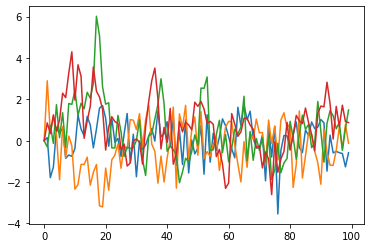

In [75]:
np.random.seed(seed = 1234)

## Number of dimensions, number of edges, number of samples
T, n, s = 100, 4, 5

### Coefficient matrix
## First approach: A is a DAG, no model mismatch
A_true = h.generate_A(n, s, tril = False, low = 0.30, high = 0.70)

# set coefficients to be positive (else oscillating which does not make sense)
for i in range(len(A_true)):
    A_true[i][i] = np.abs(A_true[i][i])

## True permutation
P_true = np.identity(n) # np.random.permutation(np.identity(n))

## Datagenerating W
W_true = P_true.T @ A_true @ P_true
print(f"True W:\n{np.round(W_true, 2)}.\n")

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

What we do: 
1. Compute $\{W_k\}_{k = 1}^{K}$. 
2. Generate $\hat{X}_{W_k}$ using $W_k$ of length $T$.

### Approach 1:
Compare MSE($W^{(k)}, X$) to MSE($\hat{W}^{(k)}, \hat{X}_{W_k}$).

### Approach 2:
Compare 

W^(1):
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.71]].

\hat(W)^(1):
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.72]].

0.0 0
W^(2):
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.64 0.71]].

\hat(W)^(2):
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.61 0.73]].

0.0 0
W^(3):
[[ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.   -0.6   0.    0.  ]
 [ 0.    0.    0.64  0.71]].

\hat(W)^(3):
[[ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.   -0.6   0.    0.  ]
 [ 0.    0.    0.63  0.67]].

0.0 0
W^(4):
[[ 0.    0.    0.    0.  ]
 [-0.4   0.    0.    0.  ]
 [ 0.   -0.6   0.    0.  ]
 [ 0.    0.    0.64  0.71]].

\hat(W)^(4):
[[ 0.    0.    0.    0.  ]
 [-0.41  0.    0.    0.  ]
 [ 0.   -0.55  0.    0.  ]
 [ 0.    0.    0.58  0.74]].

0.0 0
W^(5):
[[ 0.    0.    0.    0.  ]
 [-0.4   0.    0.    0.  ]
 [ 0.   -0.

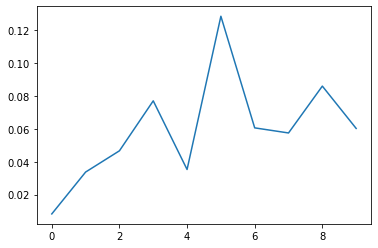

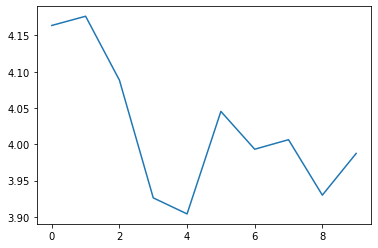

In [79]:
W, Ws, mses, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

bootstrap_mses = []
numerical_difference = []

for i, W in enumerate(Ws):
    print(f"W^({i+1}):\n{np.round(W, 2)}.\n")
    
    # generate data according to W
    X_W = h.generate_var_2(10 * T, n, W, np.identity(n))
    
    mse = h.MSE(W, X_W)
    
    # bootstrap, get \hat{W}_k
    _, bootstrap_Ws, _, _ = m._OMP_2(X_W[:-1], X_W[1:], output = True)
    bootstrap_W_k = bootstrap_Ws[i]
    print(f"\hat(W)^({i+1}):\n{np.round(bootstrap_W_k, 2)}.\n")
    
    # compare OMP and Bootstrap
    bootstrap_mses.append(h.MSE(bootstrap_W_k, X_W))
    
    # difference
    W_bin = W != 0
    W_bootstrap_bin = bootstrap_W_k != 0
    
    print(np.linalg.norm(W_bin ^ W_bootstrap_bin), 0)
    
    # check numerical differences between the two
    numerical_difference.append(np.linalg.norm(bootstrap_W_k - W))
    
plt.plot(numerical_difference)
plt.show()
plt.plot(bootstrap_mses)

### Approach 2, compare entries.